In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
import scipy.sparse
import scipy.sparse.linalg
import random

In [2]:
data = pd.read_csv('data.csv')
matrix = np.array(data)
X = (matrix[:,1:]).T
Y = matrix[:,0]

d, N = X.shape

In [3]:
def split_data(X, Y, Ntrain):
    d, N = X.shape
    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]
    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

# Test it
I1 = (Y==0)
I2 = (Y==6)
I3 = (Y==9)
X1 = X[:,I1]
X2 = X[:,I2]
X3 = X[:,I3]

Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]

Xoriginal = X
Yoriginal = Y
X = np.concatenate((X1, X2, X3), axis = 1)
Y = np.concatenate((Y1, Y2, Y3))
n_points = int(len(Y) * 8 / 10)
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, n_points)

In [4]:
def LDA(Xs, d, k):
    #creating the X matrix from the Xs tuple
    X = np.concatenate(Xs, axis = 1)

    _range = range(0, len(Xs))
    #Computing the mean of each cluster to get the centeroid of each one
    Cs = [0 for i in _range]
    for i in _range:
        Cs[i] = np.mean(Xs[i], axis = 1)
    
    #computing the mean of the data
    C_total = np.mean(X, axis = 1) 

    #computing the mean centered data for each cluster (with his mean)
    Xcs = [0 for i in _range]
    for i in _range:
        Xcs[i] = Xs[i] - Cs[i].reshape((d, 1))

    Xw = np.concatenate(Xcs, axis=1)

    #within cluster mean correlation matrix
    Sw = Xw @ Xw.T

    #computing the between cluster dataset
    Xbars = [0 for i in _range]
    for i in _range:  
        Xbars[i] = np.repeat(Cs[i].reshape(d, 1), Xs[i].shape[1], axis=1)

    X_bar = np.concatenate(Xbars, axis = 1)

    X_barC = X_bar - C_total.reshape((d, 1))

    #compute the between cluster matrix
    Sb = X_barC @ X_barC.T

    #cholesky decomposition of Sw. Possible only if positive definite, if not, we can compute a positive definite version of it
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        Sw = Sw + epsilon * np.eye(Sw.shape[0])

        L = np.linalg.cholesky(Sw)

    #computing the first k eigenvector decomposition of L^-1 Sb L
    _, W = np.linalg.eig(np.linalg.inv(L) @ Sb @ L)
    W = np.real(W[:,:k])

    # Compute Q
    Q = np.linalg.inv(L).T @ W

    return Q

In [5]:
def PCA(A, d, k):
    A_avg = np.mean(A, axis=1)
    B = A - np.tile(A_avg, (d, 1)).T
    U, s, Vt = np.linalg.svd(B, full_matrices = False)
    return (U[:, :k], B)


# Find the corresponding indeces
I1Train = (Ytrain==0)
I2Train = (Ytrain==6)
I3Train = (Ytrain==9)

# Split X and Y into X1, X2, X3 and Y1, Y2, Y3
X1Train = Xtrain[:, I1Train]
X2Train = Xtrain[:, I2Train]
X3Train = Xtrain[:, I3Train]

Y1Train = Ytrain[I1Train]
Y2Train = Ytrain[I2Train]
Y3Train = Ytrain[I3Train]

pca_U, pca_B = PCA(np.concatenate((X1Train, X2Train, X3Train), axis = 1), n_points, 2)
pca = pca_U.T @ pca_B
lda_Q = LDA((X1Train, X2Train, X3Train), d, 2)
lda = lda_Q.T @ np.concatenate((X1Train, X2Train, X3Train), axis = 1)

In [6]:
startX2Train = Y1Train.shape[0]
startX3Train = Y1Train.shape[0] + Y2Train.shape[0]

X1TrainPca = pca[:, : Y1Train.shape[0]]
X2TrainPca = pca[:,startX2Train : startX2Train + Y2Train.shape[0]]
X3TrainPca = pca[:,startX3Train:]

X1TrainLda = lda[:, : Y1Train.shape[0]]
X2TrainLda = lda[:,startX2Train : startX2Train + Y2Train.shape[0]]
X3TrainLda = lda[:,startX3Train:]

#PCA Centeroid
pcaCenteroidX1Train = np.mean(X1TrainPca, axis = 1)
pcaCenteroidX2Train = np.mean(X2TrainPca, axis = 1)
pcaCenteroidX3Train = np.mean(X3TrainPca, axis = 1)
pcaCenteroid = np.mean(pca, axis = 1)

#lda Centeroid
ldaCenteroidX1Train = np.mean(X1TrainLda, axis = 1)
ldaCenteroidX2Train = np.mean(X2TrainLda, axis = 1)
ldaCenteroidX3Train = np.mean(X3TrainLda, axis = 1)
ldaCenteroid = np.mean(lda, axis = 1)



generalCenteroid = np.mean(X, axis = 1)


In [7]:
def distance(X, center):
    _x = 0
    for x in X.T:
        _x += np.linalg.norm(x - center)
    return _x / X.shape[1]

In [8]:
pcaX1TrainDistance = distance(X1TrainPca, pcaCenteroidX1Train)
pcaX2TrainDistance = distance(X2TrainPca, pcaCenteroidX2Train)
pcaX3TrainDistance = distance(X3TrainPca, pcaCenteroidX3Train)

ldaX1TrainDistance = distance(X1TrainLda, ldaCenteroidX1Train)
ldaX2TrainDistance = distance(X2TrainLda, ldaCenteroidX2Train)
ldaX3TrainDistance = distance(X3TrainLda, ldaCenteroidX3Train)

In [9]:
pcaX1TrainGeneralDistance = distance(X1TrainPca, pcaCenteroid)
pcaX2TrainGeneralDistance = distance(X2TrainPca, pcaCenteroid)
pcaX3TrainGeneralDistance = distance(X3TrainPca, pcaCenteroid)

ldaX1TrainGeneralDistance = distance(X1TrainLda, ldaCenteroid)
ldaX2TrainGeneralDistance = distance(X2TrainLda, ldaCenteroid)
ldaX3TrainGeneralDistance = distance(X3TrainLda, ldaCenteroid)

In [10]:
# Find the corresponding indeces
I1Test = (Ytest==0)
I2Test = (Ytest==6)
I3Test = (Ytest==9)
# Split X and Y into X1, X2, X3 and Y1, Y2, Y3
X1Test = Xtest[:, I1Test]
X2Test = Xtest[:, I2Test]
X3Test = Xtest[:, I3Test]

Y1Test = Ytest[I1Test]
Y2Test = Ytest[I2Test]
Y3Test = Ytest[I3Test]

Ytest = np.concatenate((Y1Test, Y2Test, Y3Test))
Xtest = np.concatenate((X1Test, X2Test, X3Test), axis = 1)
_, pca_test_B = PCA(Xtest, Xtest.shape[1] ,2)
pca_test = pca_U.T @ pca_test_B
lda_test = lda_Q.T @ np.concatenate((X1Test, X2Test, X3Test), axis = 1) 

In [11]:
startX2Test = Y1Test.shape[0]
startX3Test = Y1Test.shape[0] + Y2Test.shape[0]

X1TestPca = pca_test[:, : Y1Test.shape[0]]
X2TestPca = pca_test[:,startX2Test : startX2Test + Y2Test.shape[0]]
X3TestPca = pca_test[:,startX3Test:]

X1TestLda = lda_test[:, : Y1Test.shape[0]]
X2TestLda = lda_test[:,startX2Test : startX2Test + Y2Test.shape[0]]
X3TestLda = lda_test[:,startX3Test:]

In [12]:
pcaX1TestDistance = distance(X1TestPca, pcaCenteroidX1Train)
pcaX2TestDistance = distance(X2TestPca, pcaCenteroidX2Train)
pcaX3TestDistance = distance(X3TestPca, pcaCenteroidX3Train)

ldaX1TestDistance = distance(X1TestLda, ldaCenteroidX1Train)
ldaX2TestDistance = distance(X2TestLda, ldaCenteroidX2Train)
ldaX3TestDistance = distance(X3TestLda, ldaCenteroidX3Train)

In [13]:
print((pcaX1TrainGeneralDistance, ldaX1TrainGeneralDistance))
print((pcaX2TrainGeneralDistance, ldaX2TrainGeneralDistance))
print((pcaX3TrainGeneralDistance, ldaX3TrainGeneralDistance))
print('------------------------------------')
print((pcaX1TrainDistance, ldaX1TrainDistance))
print((pcaX2TrainDistance, ldaX2TrainDistance))
print((pcaX3TrainDistance, ldaX3TrainDistance))
print('------------------------------------')
print((pcaX1TestDistance, ldaX1TestDistance))
print((pcaX2TestDistance, ldaX2TestDistance))
print((pcaX3TestDistance, ldaX3TestDistance))

(1121.5556167050493, 0.04025220899640704)
(712.6610459550259, 0.03869031372998693)
(805.6703912830844, 0.04866806381936549)
------------------------------------
(732.8034219644251, 0.01222917851969251)
(545.0792661846552, 0.011413366256852697)
(365.47928465586773, 0.01168880372439514)
------------------------------------
(739.4302696313679, 0.014094793760248674)
(528.2995601676582, 0.01229453026678212)
(359.8844309873626, 0.012315484443146571)


In [14]:
def classification(x, centroids, digits):
    distances = []
    for i in range(0, len(centroids)):
        distances.append(np.linalg.norm(x - centroids[i]))
    min_distance = min(distances)
    for i in range(0, len(distances)):
        if min_distance == distances[i]: return digits[i]
    return -1

def accuracy(Xs, Ys, centroids, digits):
    ok = []
    for i in range(0, len(Ys)):
        y = Ys[i]
        res = classification(Xs[:,i], centroids, digits)
        if y == res:
            ok.append(i)
    return len(ok) / len(Ys) * 100

In [15]:
# generalpca = PCA(X,X.shape[1], 2)
# generallda = LDA((X1,X2,X3),d, 2)

# startX2 = Y1.shape[0]
# startX3 = Y1.shape[0] + Y2.shape[0]

# X1Pca = generalpca[:, : Y1.shape[0]]
# X2Pca = generalpca[:,startX2 : startX2 + Y2.shape[0]]
# X3Pca = generalpca[:,startX3:]

# X1Lda = generallda[:, : Y1.shape[0]]
# X2Lda = generallda[:,startX2 : startX2 + Y2.shape[0]]
# X3Lda = generallda[:,startX3:]

# #PCA Centeroid
pcaCenteroidX1 = np.mean(X1TestPca, axis = 1)
pcaCenteroidX2 = np.mean(X2TestPca, axis = 1)
pcaCenteroidX3 = np.mean(X3TestPca, axis = 1)

#lda Centeroid
ldaCenteroidX1 = np.mean(X1TestLda, axis = 1)
ldaCenteroidX2 = np.mean(X2TestLda, axis = 1)
ldaCenteroidX3 = np.mean(X3TestLda, axis = 1)

print(accuracy(lda_test, Ytest, (ldaCenteroidX1Train, ldaCenteroidX2Train, ldaCenteroidX3Train), (0,6,9)))
print(accuracy(pca_test, Ytest, (pcaCenteroidX1Train, pcaCenteroidX2Train, pcaCenteroidX3Train), (0,6,9)))

98.07383627608347
84.43017656500803


In [18]:
class classificationForPrint:
    def __init__(self, ldaAccuracy, pcaAccuracy, dimensions, _digits) -> None:
        self.ldaAccuracy = ldaAccuracy
        self.pcaAccuracy = pcaAccuracy
        self.dimensions = dimensions
        self.digits = _digits
    
    def __str__(self) -> str:
        return f'dimensions: {self.dimensions}, digits: {self.digits}, pca: {self.pcaAccuracy}, lda: {self.ldaAccuracy}'

times = 30
n_points = int(len(Yoriginal) * 8 / 10)
(xtrain, ytrain), (xtest, ytest) = split_data(Xoriginal, Yoriginal, n_points)

accuracies = []

for i in range(0,times):
    ndigits = random.randint(2, 6)
    digits = np.random.choice(Yoriginal, ndigits)
    k = random.randint(3, d)
    YsTrain = []
    XsTrain = []
    YsTest = []
    XsTest = []
    for j in range(0, ndigits):
        Itrain = ytrain == digits[j]
        Itest = ytest == digits[j]
        YsTrain.append(ytrain[Itrain])
        XsTrain.append(xtrain[:, Itrain])
        YsTest.append(ytest[Itest])
        XsTest.append(xtest[:, Itest])
    _newXTrain = np.concatenate(XsTrain, axis = 1)
    _newXTest = np.concatenate(XsTest, axis = 1)
    train_pca_U, train_pca_B = PCA(_newXTrain, _newXTrain.shape[1], k)
    train_pca = train_pca_U.T @ train_pca_B
    train_lda_Q = LDA(XsTrain, d, k)
    train_lda = train_lda_Q.T @ _newXTrain
    _, test_pca_B = PCA(_newXTest, _newXTest.shape[1], k)
    test_pca = train_pca_U.T @ test_pca_B
    test_lda = train_lda_Q.T @ _newXTest
    pcaCentroids = []
    ldaCentroids = []
    previous = 0
    for j in range(0, ndigits):
        pcaCentroids.append(np.mean(train_pca[:, previous: previous + len(YsTrain[j])],axis = 1))
        ldaCentroids.append(np.mean(train_lda[:, previous: previous + len(YsTrain[j])],axis = 1))
        previous += len(YsTrain[j])
    accuracies.append(
        classificationForPrint(
        ldaAccuracy = accuracy(test_lda, np.concatenate(YsTest), ldaCentroids, digits),
        pcaAccuracy = accuracy(test_pca, np.concatenate(YsTest), pcaCentroids, digits),
        dimensions = k,
        _digits = digits
    ))


dimensions: 25, digits: [1 0 9], pca: 95.70783132530121, lda: 98.49397590361446
dimensions: 32, digits: [4 0 6 4], pca: 95.59178743961353, lda: 97.6147342995169
dimensions: 50, digits: [0 8 2 1 3], pca: 87.04003702846563, lda: 92.57116408238834
dimensions: 126, digits: [0 9 5 8 9], pca: 88.8138862102218, lda: 93.94889103182257
dimensions: 136, digits: [0 3 1], pca: 95.8129007921539, lda: 98.113919275745
dimensions: 146, digits: [0 3], pca: 96.62004662004662, lda: 99.18414918414918
dimensions: 163, digits: [5 3 7 8 7 9], pca: 82.44840713283911, lda: 90.14225606090965
dimensions: 166, digits: [6 9 7 9 2], pca: 90.73147486299737, lda: 93.51918036692875
dimensions: 210, digits: [7 7 3 1 5 1], pca: 89.83410493827161, lda: 94.09722222222221
dimensions: 218, digits: [6 5 1], pca: 92.31077292751301, lda: 96.1153384060873
dimensions: 320, digits: [4 5 0 2], pca: 90.35114503816793, lda: 95.38931297709924
dimensions: 324, digits: [1 8 6 5 0], pca: 87.9543834640057, lda: 92.72986457590878
dimensio

[]

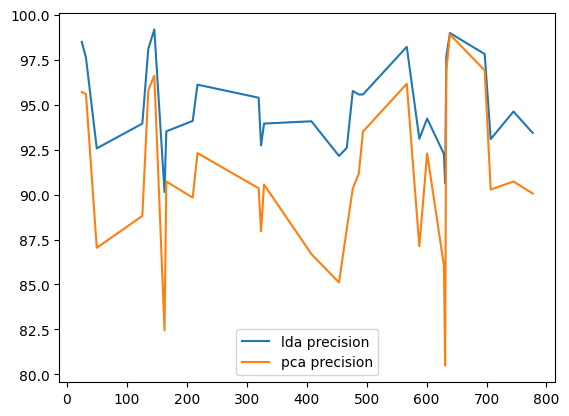

In [19]:
Key = lambda i: i.dimensions
accuracies.sort(key=Key)
for acc in accuracies:
    print(acc)

dim = [i.dimensions for i in accuracies]
lda_precision = [i.ldaAccuracy for i in accuracies]
pca_precision = [i.pcaAccuracy for i in accuracies]
plt.plot(dim,lda_precision, label = "lda precision")
plt.plot(dim,pca_precision, label = "pca precision")
plt.legend()
plt.plot()

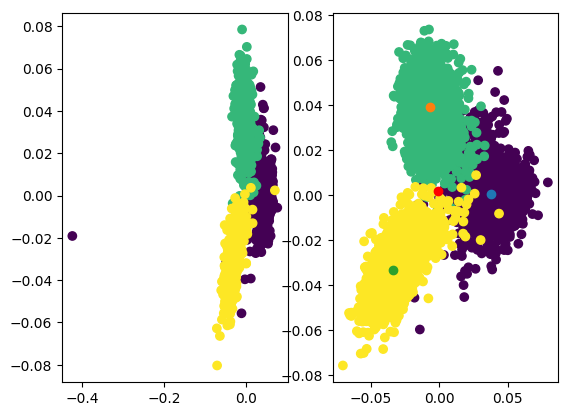

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(lda_test[0], lda_test[1], c = np.concatenate((Y1Test, Y2Test, Y3Test)))
ax2.scatter(lda[0],lda[1], c = np.concatenate((Y1Train, Y2Train, Y3Train)))
ax2.scatter(ldaCenteroid[0], ldaCenteroid[1], c = 'red')
ax2.scatter(ldaCenteroidX1Train[0], ldaCenteroidX1Train[1])
ax2.scatter(ldaCenteroidX2Train[0], ldaCenteroidX2Train[1])
ax2.scatter(ldaCenteroidX3Train[0], ldaCenteroidX3Train[1])

plt.show()

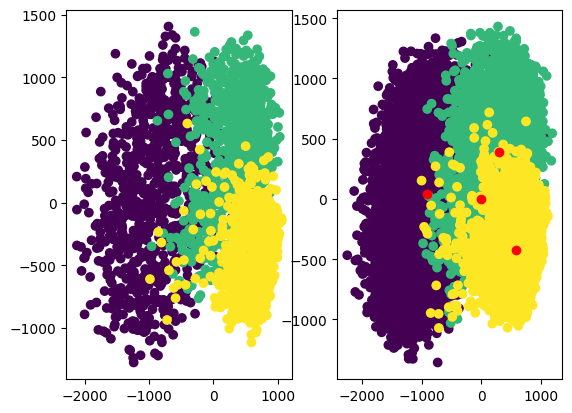

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(pca_test[0], pca_test[1], c = np.concatenate((Y1Test, Y2Test, Y3Test)))
ax2.scatter(pca[0], pca[1], c = np.concatenate((Y1Train, Y2Train, Y3Train)))
ax2.scatter(pcaCenteroid[0], pcaCenteroid[1], c = 'red')
ax2.scatter(pcaCenteroidX1Train[0], pcaCenteroidX1Train[1],c = 'red')
ax2.scatter(pcaCenteroidX2Train[0], pcaCenteroidX2Train[1],c = 'red')
ax2.scatter(pcaCenteroidX3Train[0], pcaCenteroidX3Train[1],c = 'red')
plt.show()

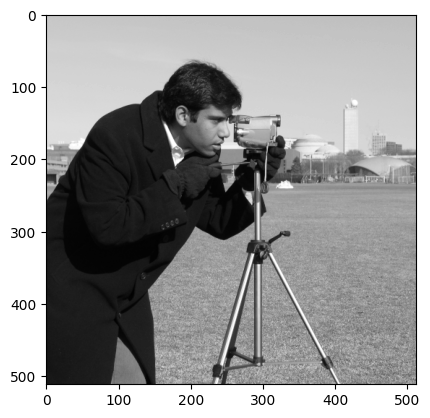

In [22]:
camera = data.camera()
U, s, Vt = np.linalg.svd(camera)
n, m = camera.shape 
plt.imshow(camera, cmap='gray')
plt.show()

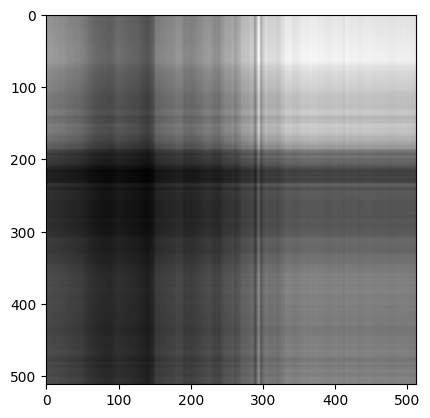

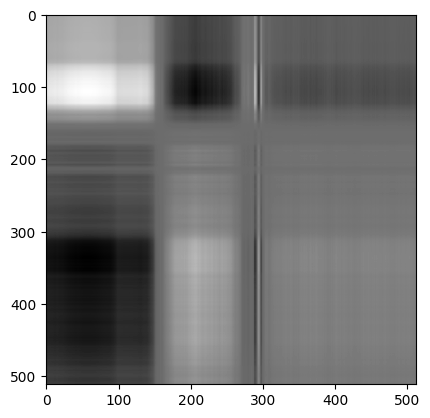

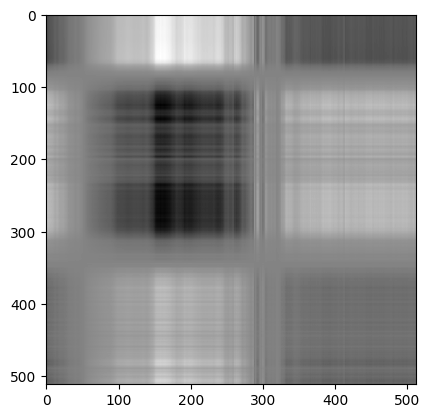

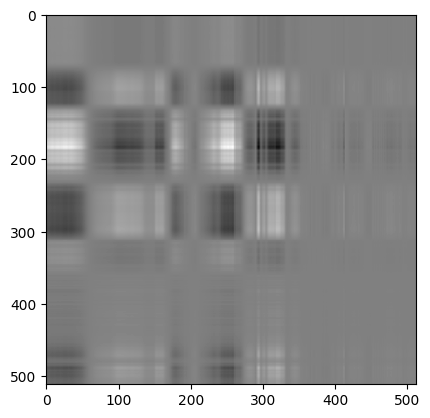

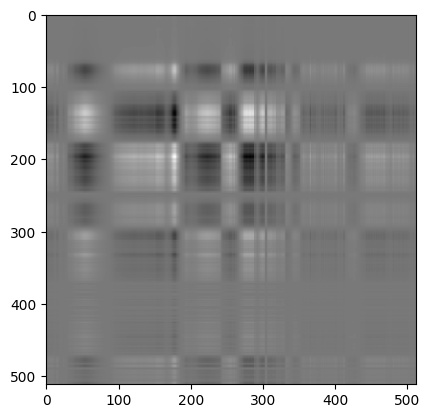

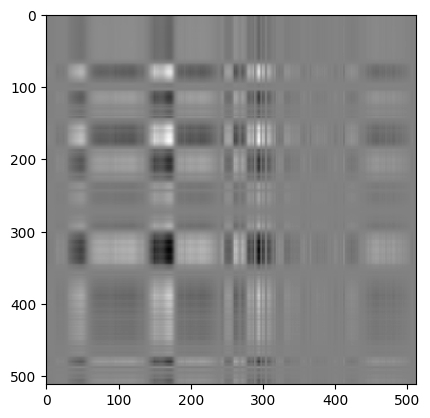

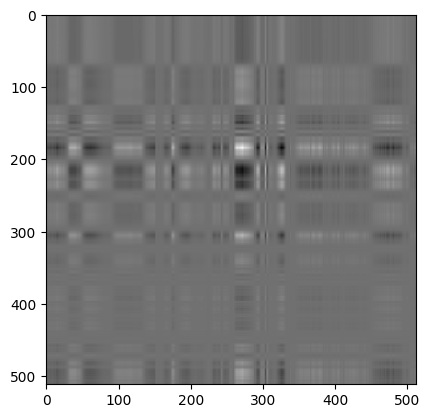

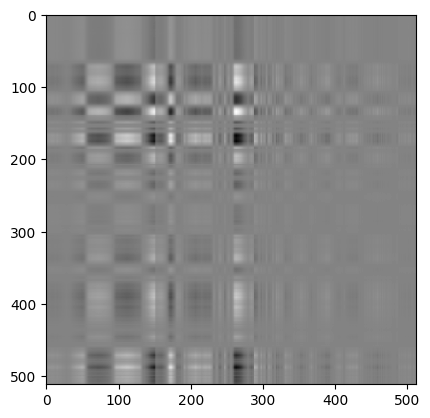

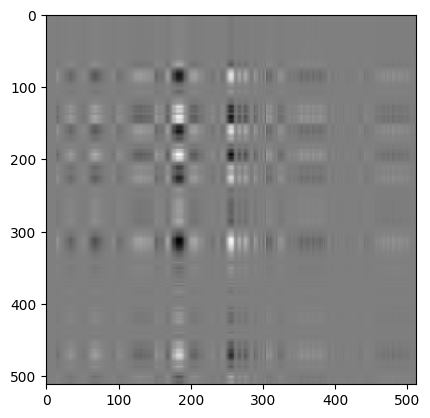

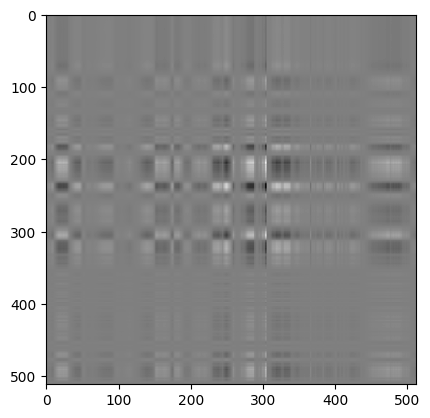

In [23]:
for i in range (0, 10):
    new_camera = s[i] * U[:,i:i+1] @ Vt[i:i+1,:] 
    plt.imshow(new_camera, cmap='gray')
    plt.show()

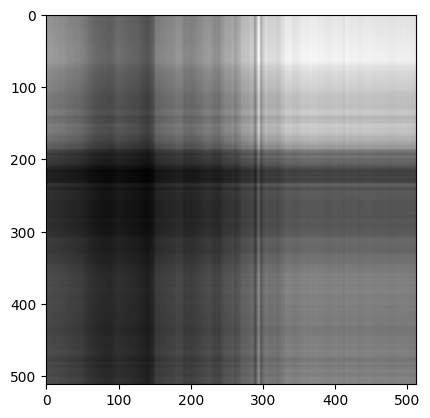

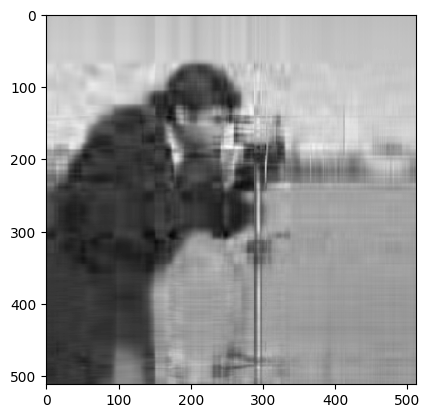

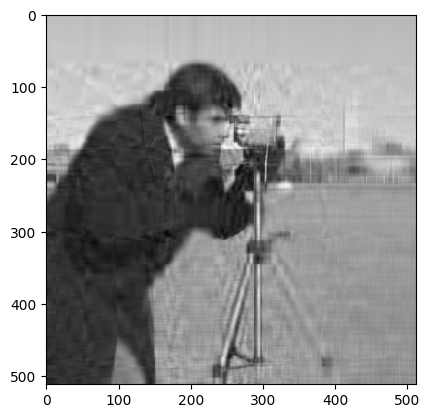

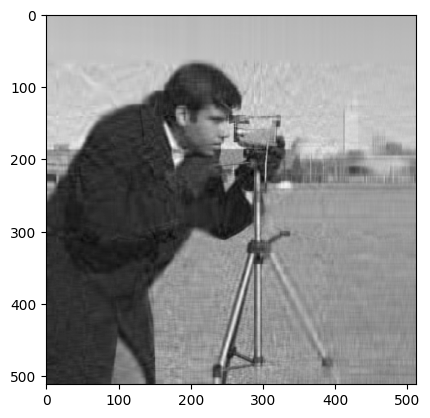

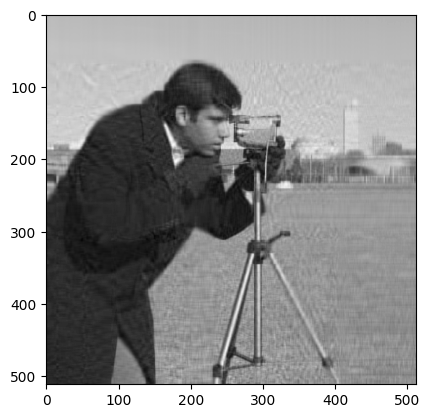

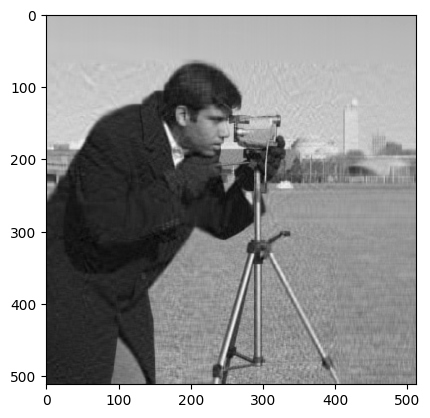

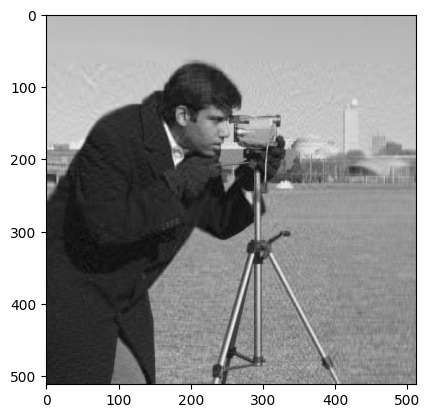

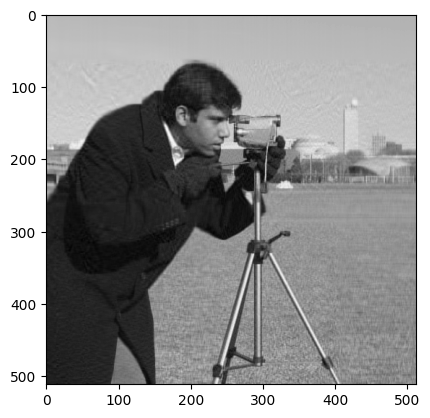

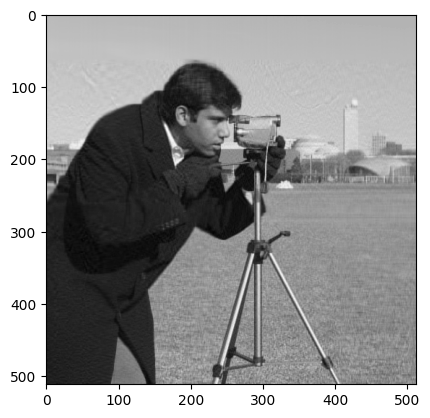

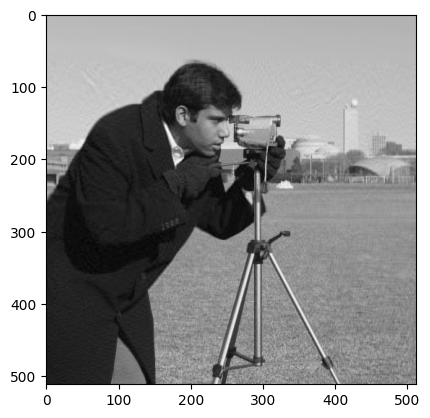

In [25]:
for i in range (1, 101, 10):
    new_camera = U[:,:i] @ np.diag(s[:i]) @ Vt[:i,:] 
    plt.imshow(new_camera, cmap='gray')
    plt.show()

0.003910064697265625


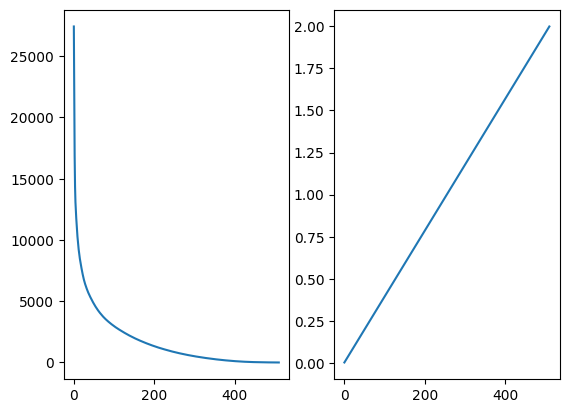

In [27]:
error = []
compression = []
comp = (1 + n + m) / (n * m)
print(comp)
for i in range (1, 512):
    new_camera = U[:,:i] @ np.diag(s[:i]) @ Vt[:i,:] 
    error.append(np.linalg.norm(camera - new_camera))
    compression.append(i * comp)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(error)
ax2.plot(compression)
plt.show()

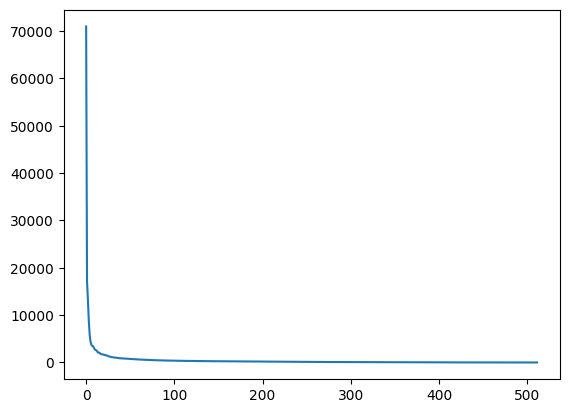

In [ ]:
plt.plot(s)
plt.show()